In [38]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch import distributions
from torchvision.utils import make_grid, save_image
import imageio
plt.style.use('ggplot')

def save_generator_image(image, path):
    save_image(image, path)

In [39]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x)
        log_sigma = self.enc_log_sigma(x)
        sigma = torch.exp(log_sigma)
        return torch.distributions.Normal(loc=mu, scale=sigma)


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        

    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = torch.tanh(self.linear2(x))
        return torch.distributions.Normal(mu, torch.ones_like(mu))

class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state):
        q_z = self.encoder(state)
        z = q_z.rsample()
        return self.decoder(z), q_z


transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalize the images to be -0.5, 0.5
     transforms.Normalize(0.5, 1)]
    )

to_pil_image = transforms.ToPILImage()

In [40]:
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

input_dim = 28 * 28
batch_size = 300
num_epochs = 2
learning_rate = 0.001
hidden_size = 512
latent_size = 16
latent_size_list = [2,8,32,128]

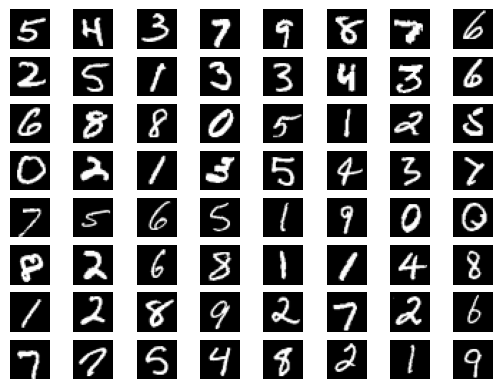

In [41]:
dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=64,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())

sample,_= next(iter(dataloader))

plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i][0], cmap="gray")
    plt.axis('off')

plt.savefig('sample')


In [42]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())

print('Number of samples: ', len(mnist))



Number of samples:  60000


In [43]:
losses = [[],[],[],[]] # to store KL loss after each epoch
losses_r = [[],[],[],[]] # to store reconstruction loss after each epoch
images = [[],[],[],[]] # to store images generatd by the generator

In [44]:
sample = sample.view(-1,input_dim).to(device)

In [45]:

for index,latent_size in enumerate(latent_size_list):
    encoder = Encoder(input_dim, hidden_size, latent_size)
    decoder = Decoder(latent_size, hidden_size, input_dim)
    vae = VAE(encoder, decoder).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        i=0
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_dim).to(device)
            optimizer.zero_grad()
            p_x, q_z = vae(inputs)
            log_likelihood = p_x.log_prob(inputs).sum(-1).mean()
            kl = torch.distributions.kl_divergence(
                q_z, 
                torch.distributions.Normal(0, 1.)
            ).sum(-1).mean()
            loss = -(log_likelihood - kl)
            loss.backward()
            optimizer.step()
            l = loss.item()
            losses[index].append(l)
            losses_r[index].append(log_likelihood.item())

            if(i%10== 0):
                sample_d,_=vae(sample)
                sample_image = sample_d.loc.view(-1,1,28,28)
                generated_img = make_grid(sample_image)
                save_generator_image(generated_img, f"./output-{latent_size}/latent{latent_size}_sample_round{i + 190*epoch}.png")
                images[index].append(generated_img)
                print(i, l, log_likelihood.item(), kl.item())
            i+=1
        torch.save(vae.state_dict(), f'./output-{latent_size}/vae{latent_size}.pth')
        imgs = [np.array(to_pil_image(img)) for img in images[index]]
        imageio.mimsave(f'./output-{latent_size}/{latent_size}-latent-sample_images.gif', imgs)


0 837.1918334960938 -837.1851806640625 0.006637520622462034
10 751.7787475585938 -750.5293579101562 1.2494086027145386
20 751.4078979492188 -748.8609619140625 2.5469284057617188
30 749.4575805664062 -747.6642456054688 1.7933260202407837
40 749.2662963867188 -748.0087280273438 1.2575836181640625
50 746.8003540039062 -745.1344604492188 1.6659132242202759
60 746.7454833984375 -744.6852416992188 2.06026029586792
70 746.5493774414062 -744.1681518554688 2.3812484741210938
80 745.32958984375 -743.0467529296875 2.282825469970703
90 745.427490234375 -742.9884643554688 2.4390125274658203
100 744.7871704101562 -742.3612060546875 2.4259696006774902
110 744.9879150390625 -742.7003784179688 2.2875139713287354
120 745.3031616210938 -742.9539184570312 2.3492448329925537
130 744.579833984375 -742.2139282226562 2.365933895111084
140 744.2564086914062 -741.8865356445312 2.3698694705963135
150 743.2260131835938 -740.9283447265625 2.2976386547088623
160 743.1666870117188 -740.9512329101562 2.21548414230346

4


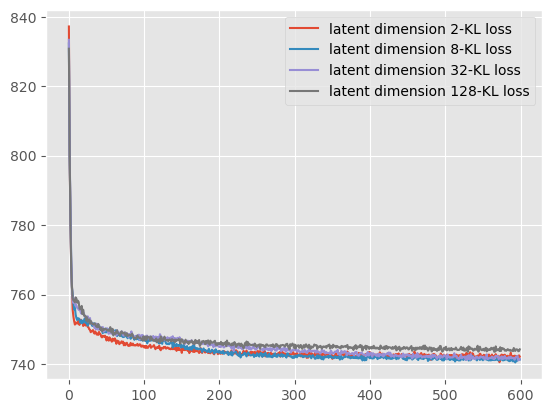

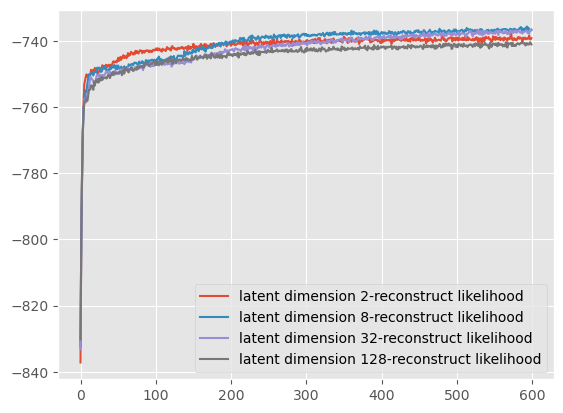

In [46]:

plt.figure()
for i,loss in enumerate(losses):
    plt.plot(loss, label=f'latent dimension {latent_size_list[i]}-KL loss')
plt.savefig('./loss.png')
plt.legend()
plt.figure()
print(len(losses_r))
for i,loss_r in enumerate(losses_r):   
    plt.plot(loss_r, label=f'latent dimension {latent_size_list[i]}-reconstruct likelihood')
    plt.legend()
plt.savefig('./loss_r.png')
